In [1]:
import json
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.patches as patches
%matplotlib inline

In [2]:
with open('trello.json','r') as f:
    trello_data = json.load(f)


In [3]:
with open('classroom.json', 'r') as f:
    lines = f.readlines()
classroom_data = [json.loads(line) for line in lines]

In [4]:
"""
создаем массив пользователей класрума и добавляем им список сданных ими работ
"""
class Clasroom_grade(object):
    def __init__(self):
        self.course_id=''
        self.work_id=''
        self.created_date=''
        self.due_date=[]
        self.due_time=[]
        self.turned_in_date=''
        self.max_points=0
        self.earned_pts=0
    
class Clasroom_usr(object):
    def __init__(self):
        self.usr_id = ''
        self.first_name =''
        self.last_name =''
        self.email = ''
        self.courses=[]
        self.grades = []
    

clasroom_users=[]
for clasroom_user_for in classroom_data:
    clasroom_user= Clasroom_usr()
    test = []
    for courses in clasroom_user_for['courses']:
        for course_Works in courses['courseWork']:
            if 'studentSubmissions' in course_Works.keys()\
            and 'submissionHistory' in course_Works['studentSubmissions']\
            and 'gradeHistory' in course_Works['studentSubmissions']['submissionHistory'][-1].keys()\
            and 'pointsEarned' in course_Works['studentSubmissions']['submissionHistory'][-1]['gradeHistory'].keys()\
            and 'maxPoints' in course_Works['studentSubmissions']['submissionHistory'][-1]['gradeHistory'].keys()\
            and  'stateHistory' in course_Works['studentSubmissions']['submissionHistory'][1].keys():
                grade = Clasroom_grade()
                grade.course_id = course_Works['courseId']
                grade.work_id=course_Works['id']
                grade.created_date=course_Works['creationTime']
                if 'dueDate' in course_Works.keys():
                    grade.due_date=(course_Works['dueDate']['year'],course_Works['dueDate']['month'],course_Works['dueDate']['day'])
                    if 'dueTime' in course_Works.keys() and 'hours' in course_Works['dueTime'].keys() and 'minutes' in course_Works['dueTime'].keys():
                        grade.due_time=(course_Works['dueTime']['hours'],course_Works['dueTime']['minutes'])
                grade.turned_in_date=course_Works['studentSubmissions']['submissionHistory'][1]['stateHistory']['timestamp']['$date']
                grade.max_points=course_Works['studentSubmissions']['submissionHistory'][-1]['gradeHistory']['maxPoints']
                grade.earned_pts=course_Works['studentSubmissions']['submissionHistory'][-1]['gradeHistory']['pointsEarned']
                test.append(grade)
                clasroom_user.grades.append(grade)
    clasroom_user.usr_id = clasroom_user_for['id']
    clasroom_user.email=clasroom_user_for['emailAddress']
    clasroom_user.first_name=clasroom_user_for['firstName']
    clasroom_user.last_name=clasroom_user_for['lastName']
    clasroom_user.courses=[courses['id'] for courses in clasroom_user_for['courses']]
    clasroom_users.append(clasroom_user)

In [5]:
"""
Здесь мы создаем массив из пользователей которые есть в трелло и сопоставлем им список их действий
Добавлять как действия будем только те actions у которых type - updateCard или updateCustomFieldItem
"""
class Action(object):
    def __init__(self):
        self.action_id=''
        self.action_type=''
        self.date=''
        self.card_id=''
        
    
class Trello_usr(object):
    def __init__(self):
        self.usr_id = ''
        self.trello_id=''
        self.name =''
        self.email = ''
        self.actions = []
    
    def print_trello_user(self):
        print(self.usr_id, self.trello_id,self.name, self.email)
        for acts in self.actions:
            print(acts.action_id, acts.action_type, acts.date, acts.card_id,'\n')
    
    
flag = 1
list_of_trello_users_with_actions=[]
trello_user=Trello_usr()
action = Action()
trello_user.actions.append(action)
list_of_trello_users_with_actions.append(trello_user)

for i in range(len(trello_data)):
    for same_email in list_of_trello_users_with_actions:
        if same_email.email==trello_data[i]['email']:
            flag = 0
    if flag == 1:
        trello_user=Trello_usr()
        trello_user.usr_id=trello_data[i]['_id']['$oid']
        trello_user.trello_id=trello_data[i]['trelloId']
        trello_user.name=trello_data[i]['fullName']
        trello_user.email=trello_data[i]['email']
        list_of_trello_users_with_actions.append(trello_user)
    flag = 1

for i in range(len(trello_data)):
    for boards in trello_data[i]['boards']:
        for actions in boards['actions']:
            if actions['type']=='updateCard' or actions['type']=='updateCustomFieldItem':
                for j in range(len(boards['cards'])):
                    if boards['cards'][j]['id']==actions['data']['card']['id']:
                        action = Action()
                        action.action_id=actions['id']
                        action.action_type=actions['type']
                        action.date=actions['date']
                        action.card_id=boards['cards'][j]['id']
                        action.action_card_id=actions['data']['card']['id']
                           
                        for users_id_in_card in boards['cards'][j]['idMembers']:
                            for user_id_in_our_list in list_of_trello_users_with_actions:
                                if users_id_in_card==user_id_in_our_list.trello_id:
                                    user_id_in_our_list.actions.append(action)
                                        #пользователь найден, добавляем ему это действие



In [6]:
# удаляем повторяющиеся действия если таковые есть
for user in list_of_trello_users_with_actions:
    for i in range(len(user.actions)):
        for j in range(i+1,len(user.actions)):
            if user.actions[i].action_id==user.actions[j].action_id:
                user.actions.pop(j)
            

In [7]:
""" 
создаем единый массив всех юзеров которые есть и в трелло и в класруме 
где каждому юзеру будет сопоставлена последовательность его действий (только время, остальное нам не так важно)
"""
class Student:
    def __init__(self):
        self.email=''
        self.actions=[]
        self.pecent=0
list_of_all_students=[]
for clasroom_student in clasroom_users:
    for trello_student in list_of_trello_users_with_actions:
        if clasroom_student.email==trello_student.email:
            student=Student()
            student.email=clasroom_student.email
            list_of_all_students.append(student)

In [8]:
len(list_of_all_students)
#пересечение trello и clasroom

516

In [9]:
""" 
здесь мы добавляем в наш список студентов которые входят и в трелло и классрум действия этих студентов по обоим
сервисам за 2020 год, переводя дату в количество дней от начала года
"""
months=[31,28,31,30,31,30,31,31,30,31,30,31]
days_count=0
for ind in range(len(list_of_all_students)):
    for clasroom_student_for_adding_dates in clasroom_users:
        if clasroom_student_for_adding_dates.email==list_of_all_students[ind].email:
            for grades_for_adding_as_a_num in clasroom_student_for_adding_dates.grades:
                date=datetime.fromisoformat(grades_for_adding_as_a_num.turned_in_date[:10]+' '+grades_for_adding_as_a_num.turned_in_date[11:16])
                if date.year==2020:
                    for i in range(date.month-1):
                        days_count+=months[i]
                    list_of_all_students[ind].actions.append(days_count + date.day)
                    days_count=0
      
    for trello_student_for_adding_dates in list_of_trello_users_with_actions:
        if trello_student_for_adding_dates.email==list_of_all_students[ind].email:
            for acts_for_adding_as_a_num in trello_student_for_adding_dates.actions:
                date=datetime.fromisoformat(acts_for_adding_as_a_num.date[:10]+' '+acts_for_adding_as_a_num.date[11:16])
                if date.year==2020:
                    for i in range(date.month-1):
                        days_count+=months[i]
                    list_of_all_students[ind].actions.append(days_count + date.day)
                    days_count=0

In [10]:
# удаляем всех пользователей у которых 0 действий за 2020 год
count =1
while(count!=0):
    count =0
    for i in range(len(list_of_all_students)):
        if ((i<len(list_of_all_students)) and (len(list_of_all_students[i].actions)==0)):
            list_of_all_students.pop(i)
            count+=1

In [11]:
len(list_of_all_students)
# количество студентов после удаления тех у которых 0 действий

465

In [12]:
#первый период с последним моментом считаем как от первого июня
fir_sem_start=1
fir_sem_pre_session=31+28+31+30+31
fir_sem_sesion_end=31+28+31+30+31+30
#второй
sec_sem_start =365-31-30-31-30
sec_sem_pre_session=365-31
sec_sem_sesion_end=365

Text(0.5, 1.0, 'Активность студентов ВШЭ по сервисам Trello и Classroom')

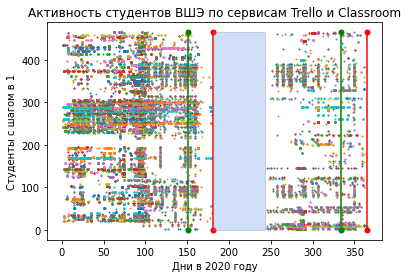

In [13]:
# можно посмотреть активность пользовтелей на графике
fig, ax = plt.subplots()

for i in range (len (list_of_all_students)):
    ax.plot(list_of_all_students[i].actions, [i+1]*len(list_of_all_students[i].actions),'o',ms='1')
ax.plot([fir_sem_pre_session,fir_sem_pre_session],[0,len(list_of_all_students)],marker='o',c='g',ms=5)
ax.plot([fir_sem_sesion_end,fir_sem_sesion_end],[0,len(list_of_all_students)],marker='o',c='r',ms=5)
ax.plot([sec_sem_pre_session,sec_sem_pre_session],[0,len(list_of_all_students)],marker='o',c='g',ms=5)
ax.plot([sec_sem_sesion_end,sec_sem_sesion_end],[0,len(list_of_all_students)],marker='o',c='r',ms=5)
#ax.plot([fir_sem_sesion_end+1,fir_sem_sesion_end+1],[0,len(list_of_all_students)],marker='o',c='b',ms=5)
#ax.plot([sec_sem_start,sec_sem_start],[0,len(list_of_all_students)],marker='o',c='b',ms=5)
ax.add_patch(Rectangle((fir_sem_sesion_end, 0), sec_sem_start-fir_sem_sesion_end, len(list_of_all_students),ec="gray", fc="CornflowerBlue",alpha=0.3, zorder=1000))
plt.xlabel('Дни в 2020 году')
plt.ylabel('Студенты с шагом в 1')
plt.title('Активность студентов ВШЭ по сервисам Trello и Classroom')
plt.savefig('graph.png',dpi=5000)
# между зелеными и красными линиями - предсессионный период, а прозрачно голубой прямоугольник - лето

In [13]:
"""
приступаем к кластеризации
смысл в том что мы хотим выделить 2 группы людей: которые работают +- равномерно в течение семестра и тех,
кто делает все в последний момент

"""

'\nприступаем к кластеризации\nсмысл в том что мы хотим выделить 2 группы людей: которые работают +- равномерно в течение семестра и тех,\nкто делает все в последний момент\n\n'

In [14]:
"""
для этого выберем оббасти которые будут считаться "последний момент" и будем делить количество работ сделанных в
 этот последний момент на общее количество работ.
 За последний момент мы выбрали промежуток - месяц до конца семестра, а за концы 1 и 2 семестров 1 января и июня
 Человека у которого больше 15% работ сдано в последний момент мы относим в группу тех кто делает все в последний момент
 Тех у кого % ниже в группу тех кто делает все равномерно
 Потом разделим группы на общее количество студентов и получим процентное соотношение 
"""

'\nдля этого выберем оббасти которые будут считаться "последний момент" и будем делить количество работ сделанных в\n этот последний момент на общее количество работ.\n За последний момент мы выбрали промежуток - месяц до конца семестра, а за концы 1 и 2 семестров 1 января и июня\n Человека у которого больше 15% работ сдано в последний момент мы относим в группу тех кто делает все в последний момент\n Тех у кого % ниже в группу тех кто делает все равномерно\n Потом разделим группы на общее количество студентов и получим процентное соотношение \n'

In [14]:
in_good_time_actions=0
for student in list_of_all_students:
    for action_of_std in student.actions:
        if action_of_std<fir_sem_pre_session or (action_of_std>sec_sem_start and action_of_std <sec_sem_pre_session):
            in_good_time_actions +=1
    student.percent=in_good_time_actions/len(student.actions)
    in_good_time_actions=0


In [15]:
good_students_count=0
for student in list_of_all_students:
    if student.percent>0.85:
        good_students_count+=1
        
print(good_students_count/len(list_of_all_students))

0.7462365591397849


In [ ]:
"""
Таким образом мы получили что % студентов делающих все своевременно и оставляют на последний месяц семестра лишь 
15% работ равен 74.6
И лишь 25.6% студентов ВШЭ "оставляют все на последний момент"
Такое прцентое соотношение по нашему субъективному мнению является хорошим показателем и 
демонстрирует хороший уровень таймменджмента у подавляющего большинства студентов ВШЭ
"""

In [ ]:
"""
А теперь посчитаем общий % работ сделанный в предсессионный период
"""
for student in list_of_all_students:
    for action_of_std in student.actions:
        if action_of_std<fir_sem_pre_session or (action_of_std>sec_sem_start and action_of_std <sec_sem_pre_session):
            in_good_time_actions +=1
        